## Compute the CubicBox data 3pcf and bk000

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from triumvirate.catalogue import ParticleCatalogue
from triumvirate.threept import compute_bispec_in_gpp_box, compute_3pcf_in_gpp_box
from triumvirate.parameters import fetch_paramset_template, ParameterSet

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
def compute_bk(pos1, fn, mode=(0,0,0), edges=(0.0025, 0.3025, 60), boxsize=2000., ngrid = 512, **args):
    """
    Compute the bispectrum for a periodic box.
    Use triumvirate codes and the basic idea is Fourrier Transform from the bispectrum.
    Parameters
    ----------
    pos1 : array-like
        Positions of sample 1 (e.g., galaxies or halos).
    fn   : str with {{}}
        Saved file name
    edges : list of arrays
        Bin edges in separation (smin, smax, nbins).
    boxsize : float
        Size of the simulation box.
    mode : tuple of int, optional
        Multipoles to project onto. Default is (0, 0, 0).
    ngrid: 
        Number of grid points along each axis for the Fast Fourier Transform (FFT). Default is 512.
    Returns
    -------
    result_threept : dict
        Dictionary containing the computed 3PCF and related quantities.
    """
    boxsize = args.get('boxsize', 2000)
    los = args.get('los', 'z')
    basedir = args.get('basedir', './test')
    (kmin, kmax, nbins) = edges
    (d_ell1, d_ell2, d_ELL) = mode
    mode_fn = f'{d_ell1}{d_ell2}{d_ELL}'
    fn_bk = fn.format(f'{mode_fn}_diag')
    if not os.path.exists(fn_bk):
        bispec_dict = fetch_paramset_template('dict')
        bispec_dict.update({
            'degrees': {'ell1': d_ell1, 'ell2': d_ell2, 'ELL': d_ELL},
            'boxsize': {'x': boxsize, 'y': boxsize, 'z': boxsize},
            'statistic_type': 'bk',
            'ngrid': {'x': ngrid, 'y': ngrid, 'z': ngrid},
            'num_bins': nbins,
            'range': [kmin, kmax],
        })
        bispec_param = ParameterSet(param_dict=bispec_dict)
        bispec_param.update(directories={'measurements':basedir+'/mpspk/'})
        CATALOGUE = ParticleCatalogue(pos1[0], pos1[1], pos1[2],  nz=len(pos1[0])/boxsize**3)
        result_bk = compute_bispec_in_gpp_box(CATALOGUE,paramset=bispec_param, save='.npz')
        fn_bk_temp = basedir+ f'/mpspk/bk{mode_fn}_diag.npz'
        os.rename(fn_bk_temp, fn_bk)
        print('save to', fn_bk, flush = True)
        return result_bk
    else:
        print(f'{fn_bk} exsits',flush=True)

In [17]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_LSS_VSMEAR
tracer = 'LRG'
boxsize = 2000.
(zmin, zmax) = REDSHIFT_LSS_VSMEAR[tracer][0]
basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph000'
data_fn = basedir + f'/catalog_rsd_xi2d_{tracer}_z{zmin:.1f}-{zmax:.1f}_velbias_B_s_mockcov.fits'
data = Catalog.read(data_fn)
pos = [data['x'],data['y'],data['z']]

In [18]:
data_args = {'boxsize':2000., 'loc':'z', 'basedir':'./test'}
results = compute_bk(pos, f'./test/mpspk/bk{{}}_test.npz', mode = (0,0,0), **data_args)

[2025-06-03 08:31:23 (+00:05:43) STAT C++] Parameters validated.
[2025-06-03 08:31:23 (+00:05:43) STAT C++] Parameters validated.
[2025-06-03 08:31:23 (+00:05:43) STAT C++] Parameters validated.
[2025-06-03 08:31:26 (+00:05:46) INFO C++] Catalogue loaded: ntotal = 2982225, wtotal = 2982225.000, wstotal = 2982225.000 (source=extdata).
[2025-06-03 08:31:27 (+00:05:46) INFO C++] Extents of particle coordinates: {'x': (0.001, 1999.999 | 1999.998), 'y': (0.001, 1999.999 | 1999.999), 'z': (0.000, 2000.000 | 1999.999)} (source=extdata).
[2025-06-03 08:31:27 (+00:05:47) STAT C++] Computing bispectrum from a periodic-box simulation-type catalogue in the global plane-parallel approximation...
[2025-06-03 08:35:02 (+00:09:21) STAT C++] Bispectrum term at orders (m1, m2, M) = (0, 0, 0) computed.
[2025-06-03 08:35:03 (+00:09:23) STAT C++] ... computed bispectrum from a periodic-box simulation-type catalogue in the global plane-parallel approximation.
save to ./test/mpspk/bk000_diag_test.npz


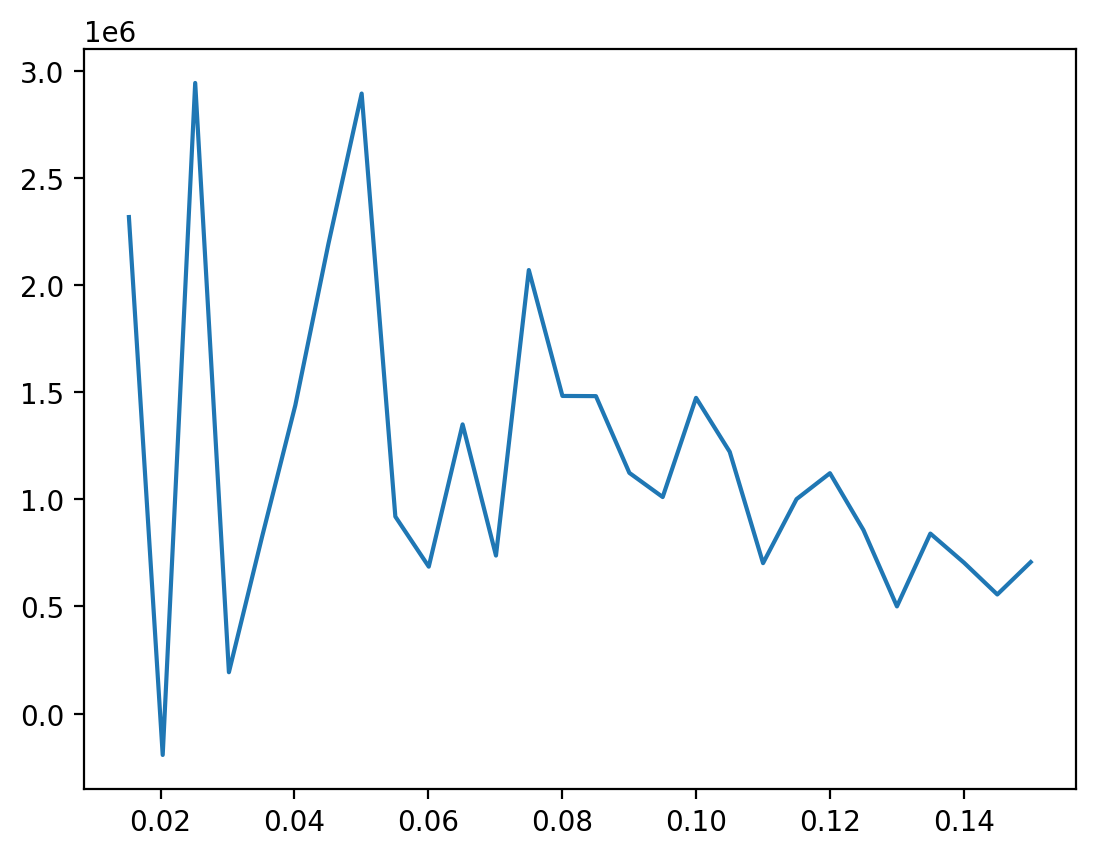

In [19]:
bk_raw = results["bk_raw"].real  # Real part of the raw bispectrum
bk_shot = results["bk_shot"].real  # Real part of the shot noise
bk = bk_raw - bk_shot
k =  results["k1_eff"]
plt.plot(k[2:30], k[2:30]**2*bk[2:30])

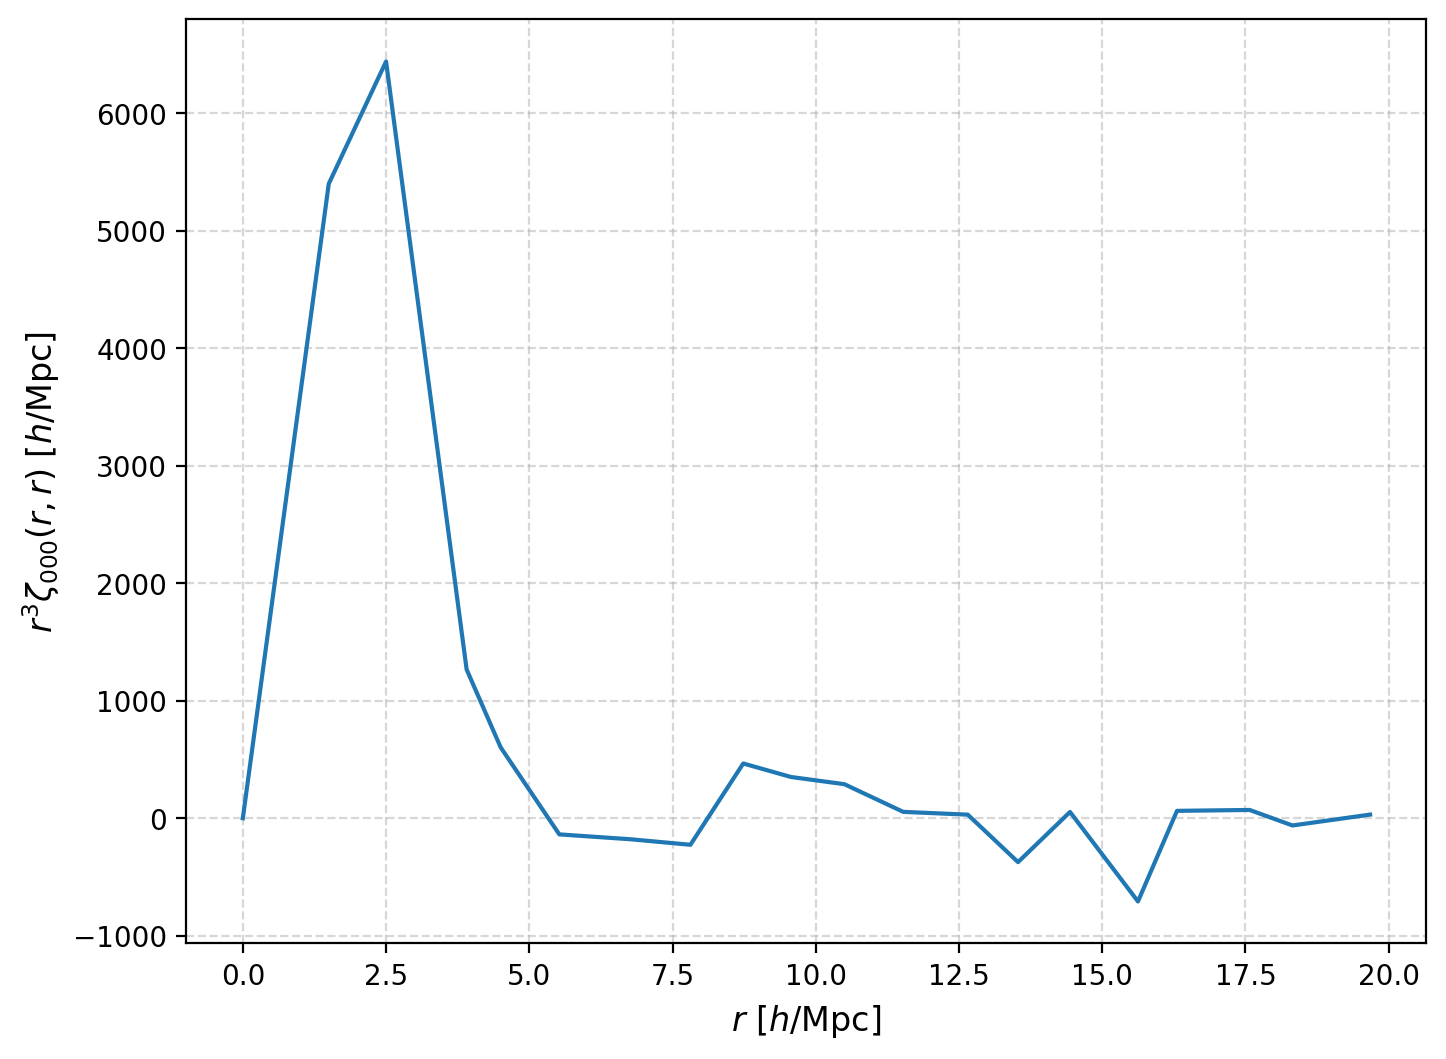

In [ ]:
# Extract relevant data
r1_eff = results["r1_eff"]  # Effective k1 values
r2_eff = results["r2_eff"]  # Effective k2 values
zeta_raw = results["zeta_raw"].real  # Real part of the raw bispectrum
zeta_shot = results["zeta_shot"].real  # Real part of the shot noise

# Compute the bispectrum after shot noise correction
zeta = zeta_raw - zeta_shot

# Create a scatter plot of the bispectrum
plt.figure(figsize=(8, 6))
sc = plt.plot(r1_eff, r1_eff**2*zeta)
plt.xlabel(r"$r$ [$h$/Mpc]")
plt.ylabel(r"$r^2\zeta_{000}(r,r)$ [$h$/Mpc]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_CUBICBOX, EDGES, GET_RECON_BIAS
from fit_cubic_tools import load_bins, load_rescalc_cov
%load_ext autoreload
%autoreload 2

In [33]:
#bk setting
tracer = 'ELG'
boxsize = 2000.
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
# bispec settings
bispec_dict = fetch_paramset_template('dict')
bispec_dict.update({
    'degrees': {'ELL': 0, 'ell1': 0, 'ell2': 0},
    'boxsize': {'x': boxsize, 'y': boxsize, 'z': boxsize},
    'statistic_type': 'bispec',
    'ngrid': {'x': 512, 'y': 512, 'z': 512},
    'num_bins': 20,
    'range': [0.005, 0.205],
})
bispec_param = ParameterSet(param_dict=bispec_dict)
basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph000'
data_fn = basedir + f'/catalog_rsd_xi2d_{tracer}_z{zmin:.1f}-{zmax:.1f}_velbias_B_s_mockcov.fits'
data = Catalog.read(data_fn)
CATALOGUE = ParticleCatalogue(data['x'],data['y'],data['z']%boxsize-boxsize/2.0, nz=len(data)/boxsize**3)
bispec_param.update(directories={'measurements':'./test'},tags={'output':'_test'})
result_bispec = compute_bispec_in_gpp_box(CATALOGUE,paramset=bispec_param, save = '.npz')

[2025-02-25 08:56:29 (+01:21:04) STAT C++] Parameters validated.
[2025-02-25 08:56:30 (+01:21:06) STAT C++] Parameters validated.
[2025-02-25 08:56:30 (+01:21:06) STAT C++] Parameters validated.
[2025-02-25 08:56:37 (+01:21:12) INFO C++] Catalogue loaded: ntotal = 6747351, wtotal = 6747351.000, wstotal = 6747351.000 (source=extdata).
[2025-02-25 08:56:37 (+01:21:12) INFO C++] Extents of particle coordinates: {'x': (0.000, 2000.000 | 2000.000), 'y': (0.000, 1999.999 | 1999.999), 'z': (0.001, 1999.999 | 1999.999)} (source=extdata).
[2025-02-25 08:56:38 (+01:21:13) STAT C++] Computing bispectrum from a periodic-box simulation-type catalogue in the global plane-parallel approximation...
[2025-02-25 08:58:04 (+01:22:40) STAT C++] Bispectrum term at orders (m1, m2, M) = (0, 0, 0) computed.
[2025-02-25 08:58:06 (+01:22:41) STAT C++] ... computed bispectrum from a periodic-box simulation-type catalogue in the global plane-parallel approximation.


In [ ]:
result_bispec

{'k1_bin': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 'k2_bin': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 'k1_eff': array([0.01159058, 0.02081665, 0.03048062, 0.04036437, 0.05036595,
        0.06034213, 0.0702755 , 0.08021871, 0.09019841, 0.10017723,
        0.11014627, 0.12013268, 0.13012506, 0.14012919, 0.15012158,
        0.16013557, 0.1701332 , 0.18010434, 0.19008708, 0.20007673]),
 'k2_eff': array([0.01159058, 0.02081665, 0.03048062, 0.04036437, 0.05036595,
        0.06034213, 0.0702755 , 0.08021871, 0.09019841, 0.10017723,
        0.11014627, 0.12013268, 0.13012506, 0.14012919, 0.15012158,
        0.16013557, 0.1701332 , 0.18010434, 0.19008708, 0.20007673]),
 'nmodes_1': array([   442,   1642,   3640,   6550,  10282,  14618,  19858,  25900,
         32986,  40426,  49090,  58334,  68626,  795

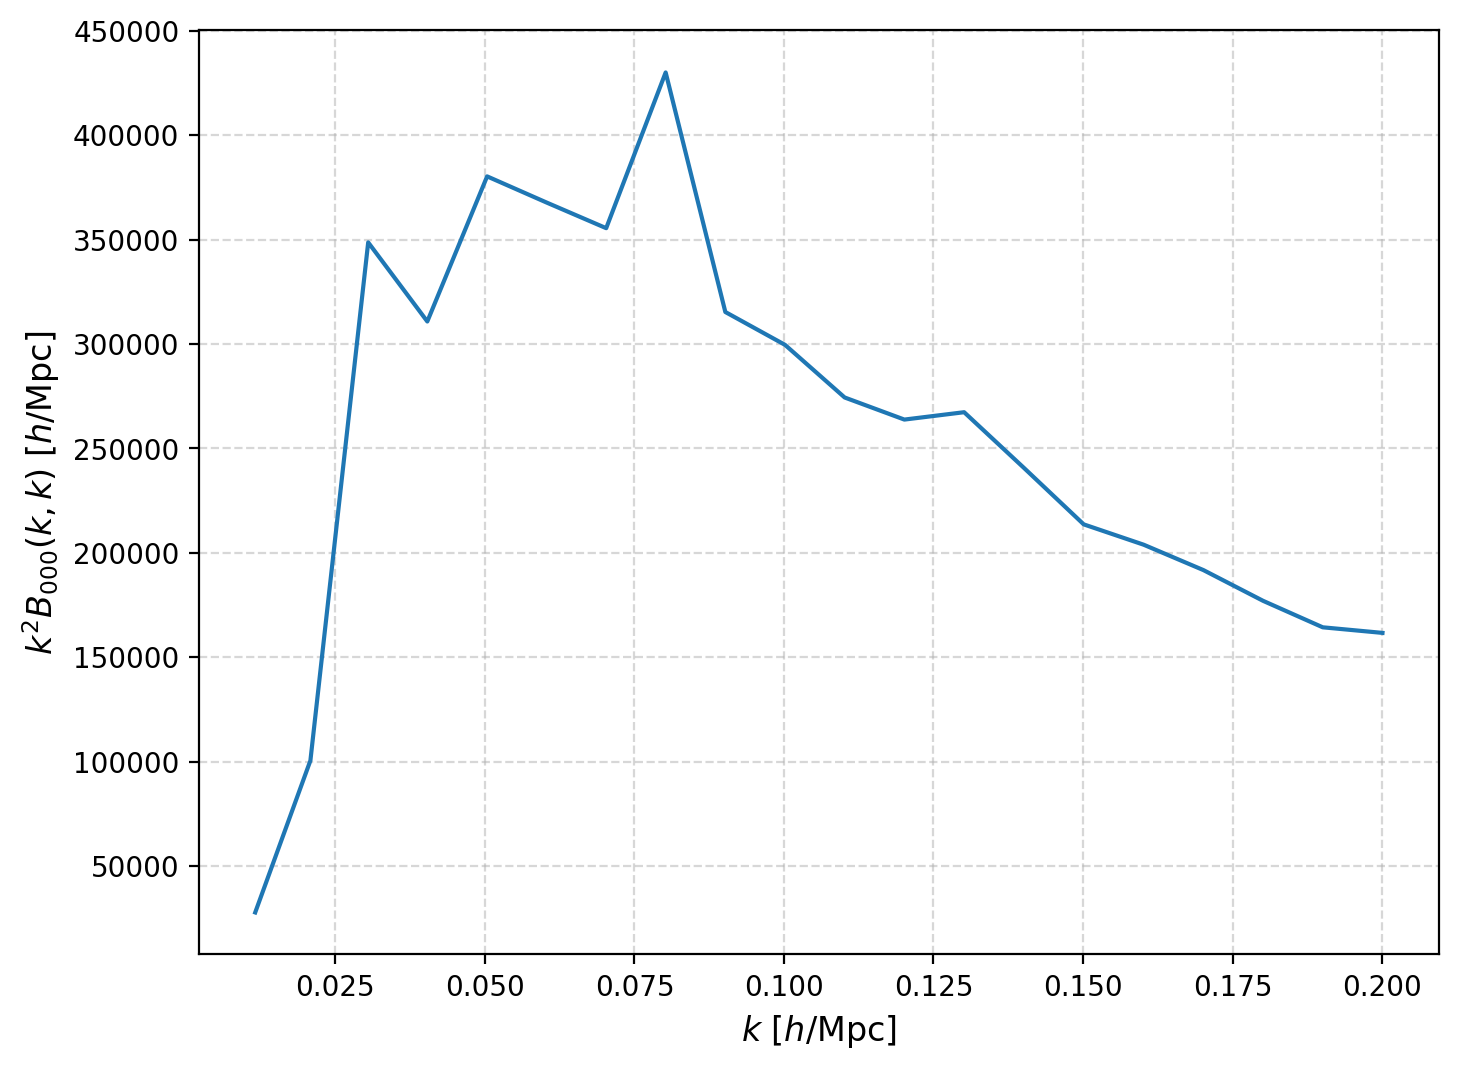

In [ ]:
# Load the .npz file
file_path = "./test/bk000_diag_test.npz"  # Update the path if needed
data = np.load(file_path, allow_pickle=True)
print("Available keys:", list(data.keys()))

# Extract relevant data
k1_eff = data["k1_eff"]  # Effective k1 values
k2_eff = data["k2_eff"]  # Effective k2 values
bk_raw = data["bk_raw"].real  # Real part of the raw bispectrum
bk_shot = data["bk_shot"].real  # Real part of the shot noise

# Compute the bispectrum after shot noise correction
bk_corrected = bk_raw - bk_shot

# Create a scatter plot of the bispectrum
plt.figure(figsize=(8, 6))
sc = plt.plot(k1_eff, k1_eff**2*bk_corrected)
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$k^2B_{000}(k,k)$ [$h$/Mpc]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [6]:
# 3pt settings
tracer = 'ELG'
boxsize = 2000.
# bispec settings
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
threept_dict = fetch_paramset_template('dict')
threept_dict.update({
    'degrees': {'ELL': 0, 'ell1': 0, 'ell2': 0},
    'boxsize': {'x': boxsize, 'y': boxsize, 'z': boxsize},
    'statistic_type': '3pcf',
    'ngrid': {'x': 512, 'y': 512, 'z': 512},
    'num_bins': 40,
    'range': [0,200],
})
threept_param = ParameterSet(param_dict=threept_dict)
basedir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph000'
data_fn = basedir+f'/catalog_rsd_xi2d_{tracer}_z{zmin:.1f}-{zmax:.1f}_velbias_B_s_mockcov.fits'
data = Catalog.read(data_fn)
CATALOGUE = ParticleCatalogue(data['x'],data['y'],data['z']%boxsize-boxsize/2.0, nz=len(data)/boxsize**3)
threept_param.update(directories={'measurements':'./test'},tags={'output':'_test'})
result_threept = compute_3pcf_in_gpp_box(CATALOGUE,paramset=threept_param, save='.npz')

[2025-02-26 02:33:18 (+00:00:02) STAT C++] Parameters validated.
[2025-02-26 02:33:20 (+00:00:03) STAT C++] Parameters validated.
[2025-02-26 02:33:20 (+00:00:03) STAT C++] Parameters validated.
[2025-02-26 02:33:27 (+00:00:10) INFO C++] Catalogue loaded: ntotal = 6747351, wtotal = 6747351.000, wstotal = 6747351.000 (source=extdata).
[2025-02-26 02:33:27 (+00:00:10) INFO C++] Extents of particle coordinates: {'x': (0.000, 2000.000 | 2000.000), 'y': (0.000, 1999.999 | 1999.999), 'z': (0.001, 1999.999 | 1999.999)} (source=extdata).
[2025-02-26 02:33:28 (+00:00:11) STAT C++] Computing three-point correlation function from a periodic-box simulation-type catalogue in the global plane-parallel approximation...
[2025-02-26 02:35:17 (+00:02:01) STAT C++] Three-point correlation function term at orders (m1, m2, M) = (0, 0, 0) computed.
[2025-02-26 02:35:19 (+00:02:02) STAT C++] ... computed three-point correlation function from a periodic-box simulation-type catalogue in the global plane-parall

In [7]:
result_threept

{'r1_bin': array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5, 192.5, 197.5]),
 'r2_bin': array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5, 192.5, 197.5]),
 'r1_eff': array([  3.34821429,   8.19680925,  13.1728029 ,  18.06440077,
         22.56761554,  27.35394798,  32.44912449,  37.48306729,
         42.5383967 ,  47.52971102,  52.58666154,  57.6334433 ,
         62.58184164,  67.57427835,  72.46369527,  77.48268918,
         82.56246054,  87.54720559,  92.54129158,  97.54810087,
      

Available keys: ['r1_bin', 'r2_bin', 'r1_eff', 'r2_eff', 'npairs_1', 'npairs_2', 'zeta_raw', 'zeta_shot', 'header']


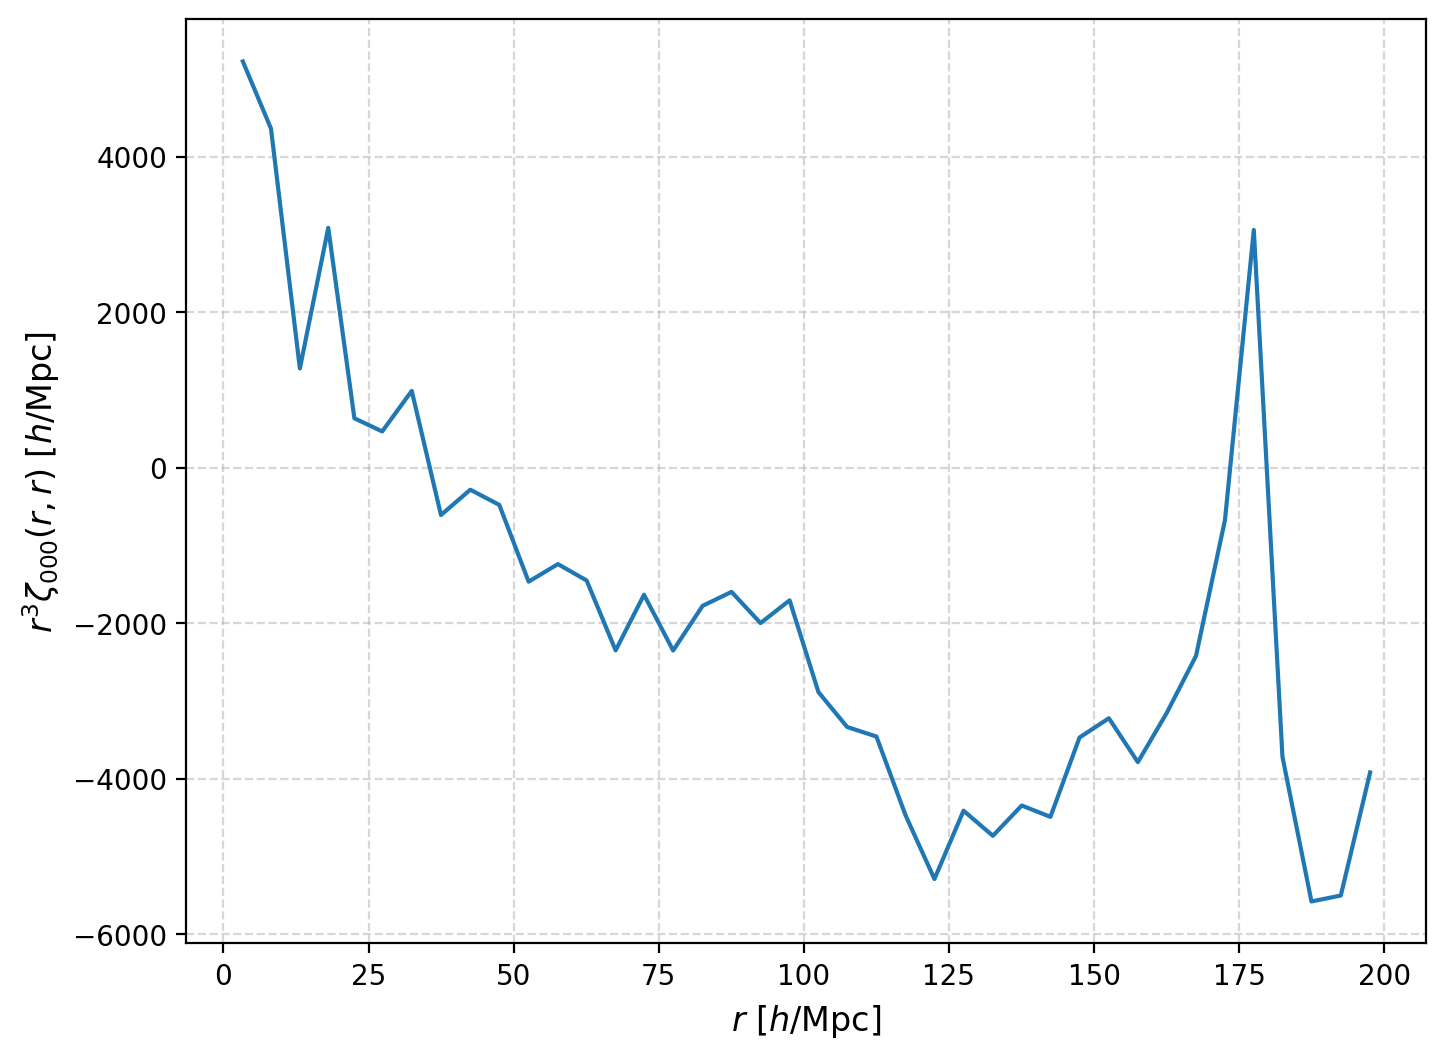

In [11]:
# Load the .npz file
file_path = "./test/zeta000_diag_test.npz"  # Update the path if needed
data = np.load(file_path, allow_pickle=True)
print("Available keys:", list(data.keys()))

# # Extract relevant data
r1_eff = data["r1_eff"]  # Effective k1 values
r2_eff = data["r2_eff"]  # Effective k2 values
zeta_raw = data["zeta_raw"].real  # Real part of the raw bispectrum
zeta_shot = data["zeta_shot"].real  # Real part of the shot noise

# Compute the bispectrum after shot noise correction
zeta = zeta_raw - zeta_shot

# Create a scatter plot of the bispectrum
plt.figure(figsize=(8, 6))
sc = plt.plot(r1_eff, r1_eff**4*zeta)
plt.xlabel(r"$r$ [$h$/Mpc]")
plt.ylabel(r"$r^3\zeta_{000}(r,r)$ [$h$/Mpc]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()